In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nltk import NaiveBayesClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import string
import re
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import random
stopwords = nltk.corpus.stopwords.words('english')
stopwords.remove("but")
pd.set_option("display.max_colwidth", 200) 
pd.set_option('display.max_rows', 500)

import warnings
warnings.filterwarnings('ignore')

In [205]:
df_train = pd.read_csv('train.csv')

In [206]:
df_train

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband lost his job and can`t afford it,d lost,negative
27477,4f4c4fc327,"I`ve wondered about rake to. The client has made it clear .NET only, don`t force devs to learn a new lang #agile #ccnet",", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - you probably need it after such hectic weekend Take care hun xxxx,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


### Check for null values and remove those tweets since we wont be able to get any information out of them

In [207]:
df_train.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [208]:
df_train.dropna(inplace=True)

df_train.shape

(27480, 4)

### Preprocess the data:

    - Remove instances of "https://..." since we do not get to know any sentinment from it
    - Removing words with less than 3 characters
    - We will then change the words to lowercase (part of standardisation)
    - We will then remove stopwords and punctuations (assumption being they dont contribute much to the meaning of the tweet)
    - Lemmatizing words
    - Keeping only words in the final text (since it is difficult to get sentiments from special characters)
    - Removed numbers also from the model
    - Join individual tokens together and return the clean text back to dataframe

In [209]:
def remove_html(tweet):
    tweet = re.sub(r'http[s]?:\/\/[\S]+',"", tweet)
    return "".join(tweet)

df_train['text_without_html'] = df_train['text'].apply(lambda x: remove_html(x))

df_train.head()

,textID,text,selected_text,sentiment,text_without_html
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,"I`d have responded, if I were going"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,Sooo SAD I will miss you here in San Diego!!!
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me...
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview! leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative,"Sons of ****, why couldn`t they put them on the releases we already bought"


In [210]:
def remove_repetitve_charaters(text):
    grp = text.group(0)
    if len(grp) > 1:
        return grp[0:2] # can change the value here on repetition
    
def unique_char(rep,sentence):
    convert = re.sub(r'(\w)\1+', rep, sentence) 
    return convert
    
df_train['without_repitition'] = df_train['text_without_html'].apply(lambda x: unique_char(remove_repetitve_charaters,x))

df_train.head()

,textID,text,selected_text,sentiment,text_without_html,without_repitition
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,"I`d have responded, if I were going","I`d have responded, if I were going"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,Sooo SAD I will miss you here in San Diego!!!,Soo SAD I will miss you here in San Diego!!!
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me...,my boss is bullying me...
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview! leave me alone,what interview! leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****, why couldn`t they put them on the releases we already bought"


In [211]:
def clean_tweets(tweet):
    tknzr = TweetTokenizer()
    tweet_words = tknzr.tokenize(tweet)
    final_list = []
    tweet_len_check = []
    tweet_words = [word for word in tweet_words if word not in stopwords]
    tweet_words = [word for word in tweet_words if word not in string.punctuation]
    tweet_words = [word.lower() for word in tweet_words]
    tweet_words = [WordNetLemmatizer().lemmatize(token) for token in tweet_words]
    for item in tweet_words:
        if len(item)>=3:
            tweet_len_check.append(item)
    tweet_words = " ".join(tweet_len_check)
    tweet_words = re.findall(r'[a-zA-Z]+', tweet_words)
    tweet_words = " ".join(tweet_words)
    
    return tweet_words


df_train['clean_text'] = df_train['without_repitition'].apply(lambda x: clean_tweets(x))

In [212]:
df_train.drop(columns = 'text_without_html',axis=1,inplace=True)

In [213]:
df_train.head()

,textID,text,selected_text,sentiment,without_repitition,clean_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,"I`d have responded, if I were going",responded going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,Soo SAD I will miss you here in San Diego!!!,soo sad miss san diego
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me...,bos bullying
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview! leave me alone,interview leave alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative,"Sons of ****, why couldn`t they put them on the releases we already bought",son put release already bought


#### To check how many 'clean_text' do not have any value (due to pre processing steps)

In [214]:
df_train_empty = df_train[df_train['clean_text']==""]
df_train_empty['sentiment'].value_counts()

neutral     84
negative     6
positive     3
Name: sentiment, dtype: int64

#### We see that around 91 tweets have no clean text. Since we will not be able to get any value out of them, we will be removing them

In [215]:
df_train = df_train[df_train['clean_text']!=""]

df_train.reset_index(drop=True,inplace=True)

In [216]:
df_train.head(10)

,textID,text,selected_text,sentiment,without_repitition,clean_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,"I`d have responded, if I were going",responded going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,Soo SAD I will miss you here in San Diego!!!,soo sad miss san diego
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me...,bos bullying
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview! leave me alone,interview leave alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative,"Sons of ****, why couldn`t they put them on the releases we already bought",son put release already bought
5,28b57f3990,http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth,http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth,neutral,- some shameless plugging for the best Rangers forum on earth,shameless plugging best ranger forum earth
6,6e0c6d75b1,2am feedings for the baby are fun when he is all smiles and coos,fun,positive,2am feedings for the baby are fun when he is all smiles and coos,am feeding baby fun smile coo
7,50e14c0bb8,Soooo high,Soooo high,neutral,Soo high,soo high
8,e050245fbd,Both of you,Both of you,neutral,Both of you,both
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe... (is that possible!?),Wow... u just became cooler.,positive,Journey!? Wow... u just became cooler. hehe... (is that possible!?),journey wow became cooler hehe possible


In [217]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27387 entries, 0 to 27386
Data columns (total 6 columns):
textID                27387 non-null object
text                  27387 non-null object
selected_text         27387 non-null object
sentiment             27387 non-null object
without_repitition    27387 non-null object
clean_text            27387 non-null object
dtypes: object(6)
memory usage: 1.3+ MB


### Exploratory Data Analysis

#### In this first we would check the following things -
    - # of positive, negative and neutral sentiments
    - Most frequent words in all three topics

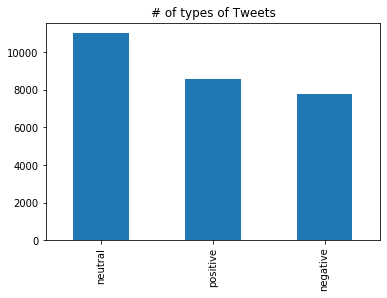

In [218]:
df_train['sentiment'].value_counts().plot(kind = 'bar', title = "# of types of Tweets")

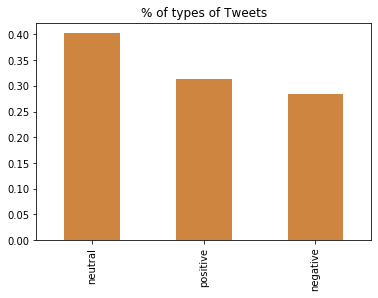

In [219]:
df_train['sentiment'].value_counts(normalize = True).plot(kind = 'bar', title = "% of types of Tweets", color = 'peru')

#### Check the top 20 most frequent words in each group

In [220]:
df_train_positive = df_train[df_train['sentiment']=='positive']
df_train_negative = df_train[df_train['sentiment']=='negative']
df_train_neutral = df_train[df_train['sentiment']=='neutral']

In [221]:
print(df_train_positive.shape)
print(df_train_negative.shape)
print(df_train_neutral.shape)

(8579, 6)
(7775, 6)
(11033, 6)


In [222]:
def word_frequency(text):
    tknzr = TweetTokenizer()
    clean_tweet_words = tknzr.tokenize(text)
    list_positive_words = []
    for word in clean_tweet_words:
        list_positive_words.append(word)
    return list_positive_words
        

list_sentence = df_train_positive.apply(lambda x: word_frequency(x.clean_text),axis=1)

list_words = []
for item in list_sentence:
    for word in item:
        list_words.append(word)

In [223]:
freq_positive_words = pd.Series(list_words).value_counts()

freq_positive_words_top_20 = freq_positive_words[0:20]

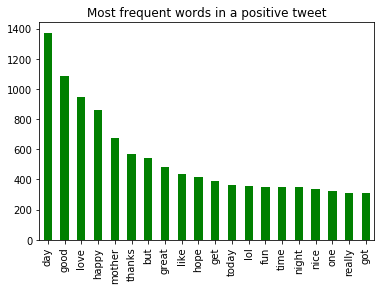

In [224]:
freq_positive_words_top_20.plot(kind='bar',color = 'green',title = 'Most frequent words in a positive tweet')

In [225]:
list_sentence = df_train_negative.apply(lambda x: word_frequency(x.clean_text),axis=1)

list_words = []
for item in list_sentence:
    for word in item:
        list_words.append(word)
        
freq_negative_words = pd.Series(list_words).value_counts()

freq_negative_words_top_20 = freq_negative_words[0:20]

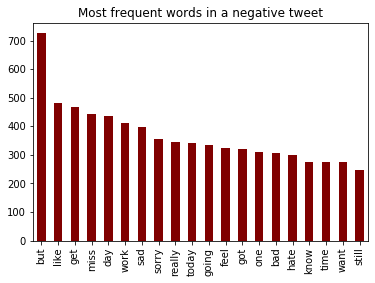

In [226]:
freq_negative_words_top_20.plot(kind='bar',color = 'maroon',title = 'Most frequent words in a negative tweet')

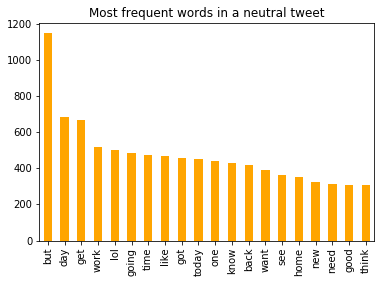

In [227]:
list_sentence = df_train_neutral.apply(lambda x: word_frequency(x.clean_text),axis=1)

list_words = []
for item in list_sentence:
    for word in item:
        list_words.append(word)
        
freq_neutral_words = pd.Series(list_words).value_counts()

freq_neutral_words_top_20 = freq_neutral_words[0:20]

freq_neutral_words_top_20.plot(kind='bar',color = 'orange',title = 'Most frequent words in a neutral tweet')


### Creating a document-term matrix

In [228]:
# We will first create a corpus of all the tweets that we have

corpus = []
for item in range(len(df_train)):
    corpus.append(df_train['clean_text'][item])

### Method 1 - To check the accuracy of model by creating a bag of word model + Various algorithms

In [229]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer( ngram_range=(1, 1))

X = vectorizer.fit_transform(corpus)
    
matrix_df = pd.DataFrame(data=X.toarray(), columns=vectorizer.get_feature_names())

y = df_train['sentiment']

### Splitting the training dataset into train and validation set, so that we can test our model

In [230]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

In [231]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(19170, 20959)
(8217, 20959)
(19170,)
(8217,)


In [232]:
clf = MultinomialNB()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

score = accuracy_score(y_val, y_pred)

score


0.6450042594620908

### Let us now perform an error analysis to find out which tweets have been mislabeleld and understand why

In [244]:
# Creating dataframe for validation set with results

y_val_df = pd.DataFrame(data = y_pred, columns = ['Predicted Sentiment'], index = y_val.index.copy())

df_val_out = pd.merge(y_val_df, df_train, how = 'inner', left_index = True, right_index = True)

df_val_out = df_val_out[['text','clean_text','sentiment','Predicted Sentiment']]

df_val_out

# Creating dataframe from validation with wrong prediction

df_val_error = df_val_out[df_val_out['sentiment']!= df_val_out['Predicted Sentiment']]

df_val_correct = df_val_out[df_val_out['sentiment']== df_val_out['Predicted Sentiment']]

print(df_val_correct.shape)
print(df_val_error.shape)
df_val_error.head(40)

(5148, 4)
(3069, 4)


,text,clean_text,sentiment,Predicted Sentiment
7995,my legs are soft watching a move with my mommm short day @ workk,leg soft watching move momm short day workk,positive,neutral
5915,Yeah I hate that too!!!! Sorry ur goin thru that,yeah hate sorry goin thru,negative,neutral
15510,http://survivingtheworld.net/Lesson5.html << I chose the wrong career,chose wrong career,negative,neutral
9836,"Man, finishing 'Operation Anchorage' sure gives you an unfair advantage, loot-wise... I love the stealth field suit and Gauss rifle",man finishing operation anchorage sure give unfair advantage loot wise love stealth field suit gauss rifle,positive,neutral
24819,_Robert ha that was ages ago! youre in LA right? the weather is much better there...,robert age ago youre right weather much better,positive,neutral
11477,My pleasure. Hear Kelli has new project! #followfriday,pleasure hear kelli new project followfriday,neutral,positive
5093,Have a great weekend Mononoke I may be tweeting from inside the movie theater either Monday or Tuesday lol,have great weekend mononoke may tweeting inside movie theater either monday tuesday lol,positive,neutral
8360,Missed you last night hon,missed last night hon,negative,neutral
2315,"Okay, the man with the hook for a hand is kinda freaking me out right now.",okay man hook hand kinda freaking right,negative,neutral
22786,why the hell is youtube not working??? NO NO NO NO NO NO NO NNO NO,hell youtube working nno,negative,neutral


In [234]:
df_train[df_train.index==25001]

,textID,text,selected_text,sentiment,without_repitition,clean_text
25001,897b6126a0,you really chose the wrong time of year to do this didnt you,chose the wrong time of year,negative,you really chose the wrong time of year to do this didnt you,really chose wrong time year didnt


In [235]:
y_val[25001]

'negative'

In [236]:
y_val_df[y_val_df.index ==25001]

,Predicted Sentiment
25001,negative


In [242]:
check = df_train[df_train["clean_text"].str.contains("danger")]
check['sentiment'].value_counts()

negative    6
neutral     3
positive    2
Name: sentiment, dtype: int64

In [243]:
check

,textID,text,selected_text,sentiment,without_repitition,clean_text
12,74a76f6e0a,My Sharpie is running DANGERously low on ink,DANGERously,negative,My Sharpie is running DANGERously low on ink,sharpie running dangerously low ink
1500,48377c4bef,"praying to be humble is always dangerous, He will answer you (God gives grace ...)","praying to be humble is always dangerous, He will answer you (God gives grace ...)",neutral,"praying to be humble is always dangerous, He will answer you (God gives grace ...)",praying humble always dangerous answer god give grace
1851,40d8340387,"I gotta say, I feel bad for everyone in NKorea. They`re starving, and they have a crazy in charge who endangers them daily.",", I feel bad for everyone in NKorea.",negative,"I gotta say, I feel bad for everyone in NKorea. They`re starving, and they have a crazy in charge who endangers them daily.",gotta say feel bad everyone nkorea they starving crazy charge endangers daily
8474,187d8df080,_nk Wouldn`t call that cool or dangerous. Reckon it fits into the stupid category,Wouldn`t call that cool or dangerous. Reckon it fits into the stupid category,negative,_nk Wouldn`t call that cool or dangerous. Reckon it fits into the stupid category,nk wouldn call cool dangerous reckon fit stupid category
9543,ee61128d20,hey Mr Danger!!!,hey Mr Danger!!!,neutral,hey Mr Danger!!!,hey danger
13268,908c222257,"Grrr, people suck. I cry when animals die on nature shows. These people are sick. No hunting endangered species!",suck.,negative,"Grr, people suck. I cry when animals die on nature shows. These people are sick. No hunting endangered species!",grr people suck cry animal die nature show these people sick hunting endangered specie
15847,321abddef7,"Warning tweeting while ridding a Bike is dangero, waaaaaaa!!! *crash*","Warning tweeting while ridding a Bike is dangero, waaaaaaa!!! *crash*",negative,"Warning tweeting while ridding a Bike is dangero, waa!!! *crash*",warning tweeting ridding bike dangero waa crash
17258,5cdfcb4a91,"http://twitpic.com/5rylt - ur so lucky! there, the stage its so close of theem! here not i think we`re dangerous (?","http://twitpic.com/5rylt - ur so lucky! there, the stage its so close of theem! here not i think we`re dangerous (?",neutral,"- ur so lucky! there, the stage its so close of theem! here not i think we`re dangerous (?",lucky stage close theem think dangerous
20949,037b1abfd0,just wanted to say that I <3 ur music(both the scene aesthetic n Danger Radio) Hopefully i will get to see u guys 1 day,t I <3 ur music,positive,just wanted to say that I <3 ur music(both the scene aesthetic n Danger Radio) Hopefully i will get to see u guys 1 day,wanted say music scene aesthetic danger radio hopefully get see guy day
21298,3bcc340f8a,ooo thanks for the danger radio link loves it...how did the test go?,ooo thanks for the danger radio link loves it..,positive,oo thanks for the danger radio link loves it...how did the test go?,thanks danger radio link love test


#### Let us try to train the model on TF-IDF vectorizer and see if there is any improvement in the accuracy

In [239]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer( ngram_range=(1, 1))

X = vectorizer.fit_transform(corpus)
    
matrix_df = pd.DataFrame(data=X.toarray(), columns=vectorizer.get_feature_names())

y = df_train['sentiment']

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

clf = MultinomialNB()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)

score = accuracy_score(y_val, y_pred)

score

0.6265060240963856

### Method 2: Extracting features and then passing them through Naives Bayes

In [36]:
df_train.head()

,textID,text,selected_text,sentiment,without_repitition,clean_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,"I`d have responded, if I were going",responded going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,Soo SAD I will miss you here in San Diego!!!,soo sad miss san diego
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me...,bos bullying
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview! leave me alone,interview leave alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative,"Sons of ****, why couldn`t they put them on the releases we already bought",son put release already bought


In [44]:
tweet_corpus_sentiment = []
for index,row in df_train.iterrows():
    tweet_corpus_sentiment.append((row['clean_text'],row['sentiment']))

In [68]:
# def tokenizing_into_words(tweet):
#     tknzr = TweetTokenizer()
#     words = tknzr.tokenize(tweet)
#     return words

# list_tweet = []
# for item in range(len(tweet_corpus_sentiment)):
#     list_tweet.append((tokenizing_into_words(tweet_corpus_sentiment[item][0]), tweet_corpus_sentiment[item][1]))

In [72]:
# def all_words_in_tweet(tweet_corpus):
#     all_words = []
#     for words, sentiment in tweet_corpus:
#         all_words.extend(words)
#     return all_words

# def all_unique_words(word_list):
#     wordlist = nltk.FreqDist(word_list)
#     word_features = wordlist.keys()
#     return word_features

# word_features = all_unique_words(all_words_in_tweet(list_tweet))

#### Creating training and test dataset

In [85]:
# ## - creating slicing index at 70% threshold
# sliceIndex = int((len(list_tweet)*.7))
# random.shuffle(list_tweet)


# train_tweet_set, test_tweet_set = list_tweet[:sliceIndex], list_tweet[sliceIndex:]
# print(len(train_tweet_set))
# print(len(test_tweet_set))


19170
8217


In [95]:
# def feature_map(tweets):
#     tweet_words = set(tweets)
#     features = {}
#     for word in word_features:
#         features['contains(%s)' % word] = (word in tweet_words)
#     return features

In [98]:
# ## - creating the feature map of train and test data

# training_set = nltk.classify.apply_features(feature_map, train_tweet_set)
# testing_set = nltk.classify.apply_features(feature_map, test_tweet_set)

# print('Training set size : ', len(training_set))
# print('Test set size : ', len(testing_set))

Training set size :  19170
Test set size :  8217


### Training

In [99]:
# ## Training the classifier with NaiveBayes algorithm
# spamClassifier = nltk.NaiveBayesClassifier.train(training_set)

In [100]:
# print(nltk.classify.accuracy(spamClassifier, testing_set))

0.6453693562127297


In [101]:
# spamClassifier.show_most_informative_features(5)

Most Informative Features
           contains(sad) = True           negati : positi =     90.4 : 1.0
          contains(suck) = True           negati : positi =     73.3 : 1.0
          contains(hate) = True           negati : positi =     56.2 : 1.0
         contains(bored) = True           negati : positi =     42.8 : 1.0
         contains(thank) = True           positi : negati =     41.4 : 1.0
